# FCC-ee radiation

In [1]:
%matplotlib widget

In [2]:
import xtrack as xt
import xobjects as xo

import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e as qe
from scipy.constants import c as clight

### Load machine model

In [3]:
line = xt.Line.from_json('../../xtrack/examples/fcc_ee_solenoid/fccee_t_with_sol_corrected.json')

Loading line from dict:   0%|          | 0/116828 [00:00<?, ?it/s]

Done loading line from dict.           


#### RF and solenoid correction

In [4]:
line.vars['voltca1'] = 75       # RF on
line.vars['voltca2'] = 349.77   # RF on
line.vars['on_sol_ip.1'] = 1    # Solenoid on
line.vars['on_corr_ip.1'] = 1   # Solenoid correction on 

#### Twiss with no radiation

In [5]:
tw_rad_off = line.twiss(method='4d')

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


### Configure radiation

In [6]:
line.configure_radiation(model='mean') # Radiation without quantum fluctuations

#### Twiss with radiation (with initial conditions)

In [7]:
tw_rad_on = line.twiss(start='ip.4', end='ip.4.l', init=tw_rad_off)

Found suitable prebuilt kernel `only_xtrack_with_synrad_kick_as_co`.


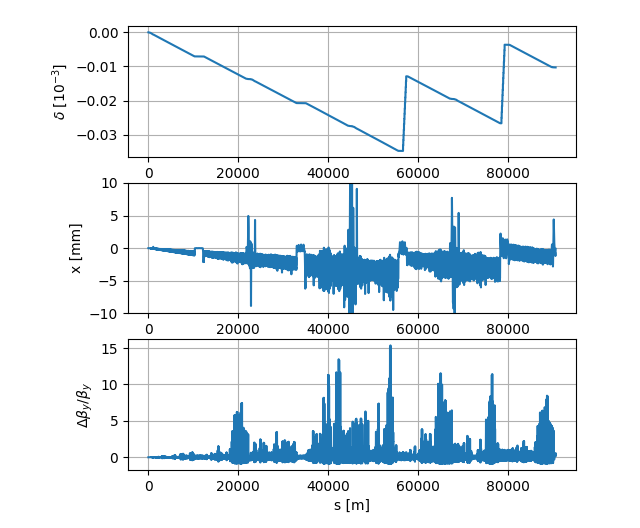

In [8]:
plt.figure(figsize=(6.4, 4.8*1.1))
ax1 = plt.subplot(3,1,1)
plt.plot(tw_rad_on.s, tw_rad_on.delta, label='before compensation')
plt.grid()
plt.ylabel(r'$\delta$ [$10^{-3}$]')

ax2 = plt.subplot(3,1,2, sharex=ax1)
plt.plot(tw_rad_on.s, tw_rad_on.x*1e3,)
plt.ylim(-10, 10)
plt.ylabel('x [mm]')
plt.grid()

ax2 = plt.subplot(3,1,3, sharex=ax1)
plt.plot(tw_rad_on.s, tw_rad_on.betx / tw_rad_off.betx - 1)
plt.ylabel(r'$\Delta \beta_y / \beta_y$')
plt.xlabel('s [m]')
plt.grid()

plt.subplots_adjust(left=.2, top=.95, hspace=.2)

### Energy loss compensation

Adjust magnet strength to actual energy (tapering) and phase RF cavities

In [9]:
line.compensate_radiation_energy_loss()

Compensating energy loss.
Found suitable prebuilt kernel `only_xtrack_frozen_longitudinal`.
Found suitable prebuilt kernel `only_xtrack_with_synrad`.
Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.
Share energy loss among cavities (repeat until energy loss is zero)
Found suitable prebuilt kernel `only_xtrack_taper`.
Energy loss: 9115673866.355 eV             
Energy loss: 447222577.862 eV             
Energy loss: 23200141.587 eV             
Energy loss: 1206826.036 eV             
Energy loss: 62785.636 eV             
Energy loss: 3266.476 eV             
Energy loss: 169.941 eV             
Energy loss: 8.842 eV             

  - Set delta_taper
  - Restore cavity voltage and frequency. Set cavity lag


#### Twiss after compensation

In [10]:
tw_compens_on = line.twiss()

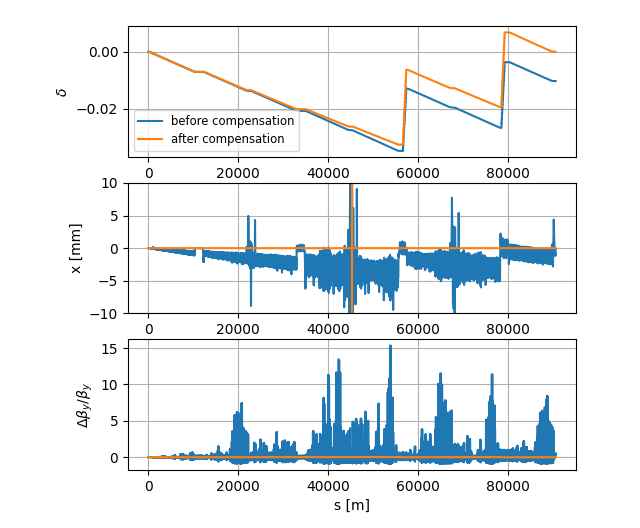

In [11]:
plt.figure(figsize=(6.4, 4.8*1.1))
ax1 = plt.subplot(3,1,1)
plt.plot(tw_rad_on.s, tw_rad_on.delta, label='before compensation')
plt.plot(tw_rad_on.s, tw_compens_on.delta, color='C1', label='after compensation')
plt.grid()
plt.ylabel(r'$\delta$')
plt.legend(fontsize='small')

ax2 = plt.subplot(3,1,2, sharex=ax1)
plt.plot(tw_rad_on.s, tw_rad_on.x*1e3,)
plt.plot(tw_rad_on.s, tw_compens_on.x*1e3, color='C1')
plt.ylim(-10, 10)
plt.ylabel('x [mm]')
plt.grid()

ax2 = plt.subplot(3,1,3, sharex=ax1)
plt.plot(tw_rad_on.s, tw_rad_on.betx / tw_rad_off.betx - 1)
plt.plot(tw_rad_on.s, tw_compens_on.betx / tw_rad_off.betx - 1, color='C1')
plt.ylabel(r'$\Delta \beta_y / \beta_y$')
plt.xlabel('s [m]')
plt.grid()

plt.subplots_adjust(left=.2, top=.95, hspace=.2)

### Computation of radiated power per unit length

#### Extract strengths and element lengths

In [12]:
tt=line.get_table(attr=True) 
energy0 = tw_rad_on.particle_on_co.energy0[0]
mask_ip = tt.name == 'ip.1'
s_ip = tt['s', 'ip.1']

# Solenoid field
brho = line.particle_ref.p0c[0] / clight / line.particle_ref.q0
Bz = tt.ks * brho

#### Compute power per unit length

In [13]:
mask_len = tt.length > 0
dE = -(np.diff(tw_compens_on.ptau) * tw_compens_on.particle_on_co.energy0[0])
dE_ds = tt.s * 0
dE_ds[mask_len] = dE[mask_len[:-1]] / tt.length[mask_len]

#### Plot

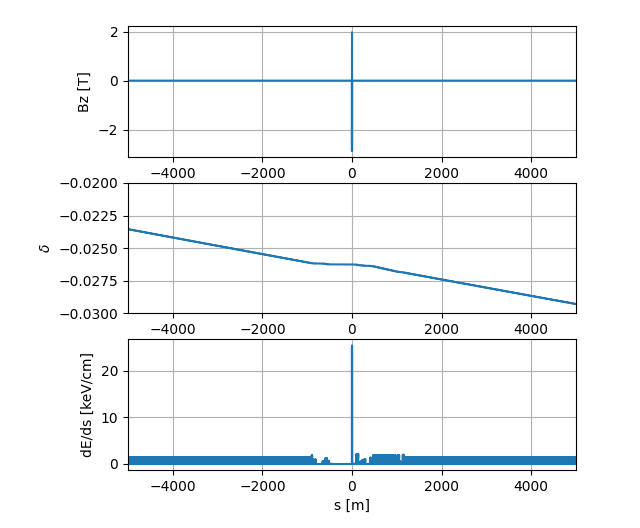

In [16]:
plt.figure(figsize=(6.4, 4.8*1.1))
ax1 = plt.subplot(3, 1, 1)
plt.plot(tt.s[~mask_ip] - s_ip, Bz[~mask_ip])
plt.ylabel('Bz [T]')
plt.grid()

ax2 = plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(tw_compens_on.s - s_ip, tw_compens_on.delta)
plt.ylabel(r'$\delta$')
plt.ylim(-0.03, -0.02)
plt.grid()

ax3 = plt.subplot(3, 1, 3, sharex=ax1)
plt.plot(tw_compens_on.s - s_ip, dE_ds * 1e-2 * 1e-3, '-', label='dE/ds')
plt.ylabel('dE/ds [keV/cm]')
plt.xlim(-5000, 5000)
plt.xlabel('s [m]')
plt.grid()

plt.subplots_adjust(left=.2, top=.95, hspace=.2)

### Damping and equilibrium emittance from twiss calculation

In [17]:
tw = line.twiss(eneloss_and_damping=True, radiation_method='full')

In [19]:
1 / tw.damping_constants_turns # Damping times

array([37.57708594, 37.57676012, 18.78827113])

In [20]:
tw.partition_numbers

array([0.99999442, 1.00000309, 2.00001778])

In [21]:
tw.eq_gemitt_x, tw.eq_gemitt_y, tw.eq_gemitt_zeta

(1.5861434359435912e-09, 9.091362048898227e-18, 2.77546825106724e-06)

In [22]:
# Equilibrium beam sizes
beam_sizes = tw.get_beam_covariance(
    gemitt_x=tw.eq_gemitt_x, gemitt_y=0*tw.eq_gemitt_y,
    gemitt_zeta=tw.eq_gemitt_zeta)

In [23]:
# Equilibrium beam sizes at IP.1
beam_sizes.rows['ip.1'].cols['sigma_x sigma_y sigma_zeta']

Table: 1 row, 4 cols
name                     sigma_x     sigma_y sigma_zeta
ip.1                 4.03946e-05 1.18494e-09 0.00171588

## Tracking with radiation

In [25]:
num_particles_test = 200
n_turns_track_test = 200

#### Build a set of particles on the closed orbit

In [31]:
p = line.build_particles(num_particles=num_particles_test)

#### Enable quantum fluctuations

In [32]:
line.configure_radiation(model='quantum') 

#### Enable multicore parallelization

In [33]:
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads='auto'))

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


#### Track

In [34]:
line.track(p, num_turns=n_turns_track_test, turn_by_turn_monitor=True, time=True,
           with_progress=10)

Tracking:   0%|          | 0/200 [00:00<?, ?it/s]

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


#### Plot beam sizes at IP

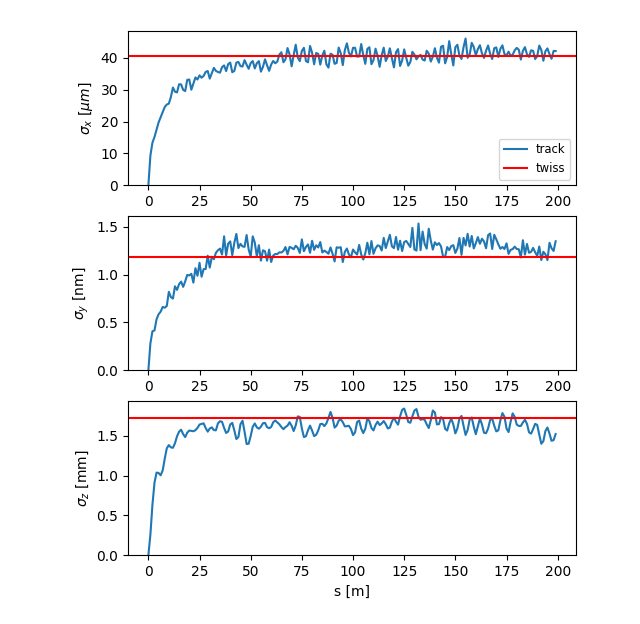

In [36]:
mon = line.record_last_track

fig = plt.figure(figsize=(6.4, 4.8*1.3))

spx = fig. add_subplot(3, 1, 1)
spx.plot(1e6 * np.std(mon.x, axis=0), label='track')
spx.axhline(1e6 * beam_sizes['sigma_x', 'ip.1'], color='red', label='twiss')
spx.legend(loc='lower right', fontsize='small')
spx.set_ylabel(r'$\sigma_{x}$ [$\mu m$]')
spx.set_ylim(bottom=0)

spy = fig. add_subplot(3, 1, 2, sharex=spx)
spy.plot(1e9 * np.std(mon.y, axis=0), label='track')
spy.axhline(1e9 * beam_sizes['sigma_y', 'ip.1'], color='red', label='twiss')
spy.set_ylabel(r'$\sigma_{y}$ [nm]')
spy.set_ylim(bottom=0)

spz = fig. add_subplot(3, 1, 3, sharex=spx)
spz.plot(np.std(1e3*mon.zeta, axis=0))
spz.axhline(1e3*beam_sizes['sigma_zeta', 'ip.1'], color='red', label='twiss')
spz.set_ylabel(r'$\sigma_{z}$ [mm]')
spz.set_ylim(bottom=0)
spz.set_xlabel('s [m]')
plt.subplots_adjust(left=.2, top=.95, hspace=.2)